In [ ]:
import os
from IPython.display import clear_output

! pip install --upgrade google-cloud-vision -q
! pip install jellyfish -q
! pip install Pillow -q
! pip install dateparser -q
! pip install ipython-autotime -q
! pip install validate_docbr  -q
# ! pip install pdf2image -q
! apt-get install poppler-utils  -q
! pip install deskew -q
! pip install scikit-image -q
! pip install googledrivedownloader -q
! pip install spacy==2.3.5 -q
! apt install libzbar0 
! pip install pyzbar -q
! pip install gspread-pandas -q
! pip install boto3 -q
! pip install awscli -q
! pip install opencv-contrib-python==4.4.0.40
clear_output()
os.kill(os.getpid(), 9)

     |████████████████████████████████| 471kB 5.5MB/s 
     |████████████████████████████████| 512kB 20.6MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 645kB 16.3MB/s 
     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 286kB 4.0MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 1s (306 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-

In [ ]:
!curl  --request POST 'http://machine-learning.easydocs.com.br/' --form 'image=@/content/drive/MyDrive/canhotos/WhatsApp Image 2021-02-05 at 12.29.52.jpeg' --form 'find=["RECEBEMOS DE"]'

{"ARQUIVO":"http://prd-easydoc-mltraining.s3.us-east-1.amazonaws.com/20210224095141767151_WhatsAppI.jpeg","ASSINADO":true,"COMPLETE_TEXT":"DONDRIL\nSa\nFECEBER OS\n05 PRODUTOS\nLADO\n70\nSERVIÇOS\nCONSTANTES\nDA\nNOTA\nFISCAL\nELETRONICA\nISDICADA\nDATALE RECEBIMENTO\nIDENTIFICAÇÃO E ASSINATURA DO RECEBEDOR\nSERIE 1\nN\" 001950784\nNOTA FISCAL\n","DATADO":false,"DATE":"","NOTA_FISCAL":"001950784","OCR_CONFIDENCE":82.13,"RECEBEMOS DE":{"FOUND_TEXT":"RECEBEDOR SE","SIMILARIDADE":75.0},"SERIE":"1","TIME":"7.22s"}


In [ ]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

from google.cloud.vision_v1p4beta1 import types,ImageAnnotatorClient
from google.colab import drive
from IPython.display import clear_output
from matplotlib import pyplot as plt
from time import time
import numpy as np
from PIL import Image
import pandas as pd
from functools import reduce 
from ipywidgets import Dropdown, interact
from matplotlib import pyplot as plt
# from pdf2image import convert_from_path
import sys, os
import cv2
from shapely.geometry import MultiPolygon, Polygon,Point, LineString
from copy import deepcopy
from flask import Flask, jsonify, request
from pprint import pprint
import base64
from spacy import load
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Easydocs/utils')

import ocr,paths,plots,spread_sheet, processing as pro, text_extraction as tex
from plots import compare_images as pc
path = r"/content/drive/MyDrive/Colab Notebooks/Easydocs/credentials/GoogleVision.json"
drive.mount('/content/drive')

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = ImageAnnotatorClient()

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Easydocs/models/ner_model/model.zip" -d /content 
nlp= load("/content/content/model")


caminho_teste = ['/content/drive/My Drive/Colab Notebooks/Easydocs/Base_compartilhada/CANHOTOS/BOMBRIL',
                 '/content/drive/MyDrive/canhotos']

find = {"find":["RECEBEMOS DE"]}
dacte = paths.find_files('/content/drive/My Drive/Colab Notebooks/Easydocs/documents/DACTE')
erros = np.array(paths.find_files(caminho_teste[1]),dtype='object')
clear_output()
print("Quantidade de arquivos: ",len(erros))

COR_POLIGONO_PALAVRA = (0,0,255)
COR_POLIGONO_CAMPO = (255,125,125)
COMPRIMENTO_PADRAO_IMAGEM = 1500
MIN_QUALIDADE_OCR = 68
plt.rcParams['figure.dpi'] = 300


ERRO_BAIXA_QUALIDADE  = {"ERROR" : "IMAGEM POSSUI BAIXA QUALIDADE"}
ERRO_LEITURA          = {"ERROR" : "FALHA AO FAZER LEITURA"}
ERRO_CONTEUDO_CANHOTO = {"ERROR" : "IMAGEM DEVE CONTER APENAS O CONHOTO"}
ERRO_CANHOTO_PARCIAL  = {"ERROR" : "LEITURA PARCIAL DO CANHOTO"}


app = Flask(__name__)

Quantidade de arquivos:  106
time: 9.92 s (started: 2021-02-24 12:52:03 +00:00)


In [ ]:
from shapely.geometry import MultiPolygon, Polygon,Point, LineString
!ln -s "/content/drive/MyDrive/Colab Notebooks/Easydocs/yolo/" /yolo
def build_yolo_net(yolo_path):

    weights_path = os.path.sep.join([yolo_path, 'pesos/yolov4_custom_best.weights'])
    config_path = os.path.sep.join([yolo_path, 'yolov4_custom.cfg'])
    names_path = os.path.sep.join([yolo_path, 'obj.names'])
    names = open(names_path, 'rt').read().split("\n")
    net = cv2.dnn_DetectionModel(config_path, weights_path)
    net.setInputSize(608, 608)
    net.setInputScale(1.0 / 255)
    net.setInputSwapRB(True)

    return net

net = build_yolo_net('/yolo')

time: 2.81 s (started: 2021-02-24 12:52:13 +00:00)


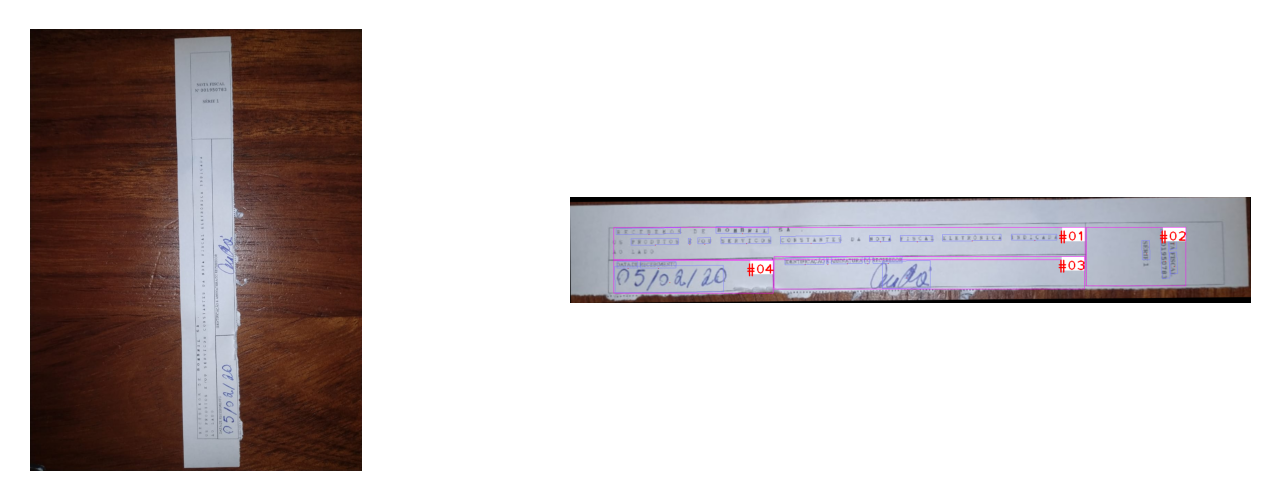

{'ASSINADO': True,
 'COMPLETE_TEXT': ' RESES PRODUTOS BONBRIL E OU SERVICOS CONSTANTES NOTA '
                  'FISCAL ELETRONICA INDICADA SERIE N 00195073 NOTA FISCAL '
                  'IDENTIFICACAO E ASORTATURA DO RECEBEDOR DATADE RECEBDENTO '
                  '05/08/20 AULA  ',
 'DATADO': True,
 'DATE': '05/08/20',
 'NOTA_FISCAL': '',
 'OCR_CONFIDENCE': 81.2,
 'RECEBEMOS DE': {'FOUND_TEXT': 'RECEBEDOR DA', 'SIMILARIDADE': 75.0},
 'TIME': '5.8s'}
0 :  WhatsApp Image 2021-02-05 at 12.29.50.jpeg 
------------------------------------------------------------------------------------------------------------------------------------------------------
time: 6.35 s (started: 2021-02-24 12:52:53 +00:00)


In [ ]:
# TRAIN_DATA = []

for num,path in enumerate(erros[-2:-1]): #
    try:
        inicio = time()
        # image_object = bucket.Object(path)

        # image_ = cv2.imdecode(np.frombuffer(image_object.get()['Body'].read(), np.uint8), -1)

        try: image_ = cv2.imread(path)
        except: image_ = np.asarray(Image.open(path))
        
        image_ori = pro.rotate(image_)
        cropped,response = ocr.align_image(image_ori,COMPRIMENTO_PADRAO_IMAGEM,net=net)
        cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/Easydocs/yolo/OID/Dataset/test/Box/{path}',
                    cropped)
        if response == 400:
             with app.app_context():print(jsonify(ERRO_LEITURA).data)

        poligonos = pro.find_polygons(response)


        if round(np.array(poligonos)[:,2].mean()*100,2) < MIN_QUALIDADE_OCR:
            with app.app_context():print(jsonify(ERRO_BAIXA_QUALIDADE).data)


        response.text = f" {tex.remove_accents(response.text)} ".replace(" SERIE O "," SERIE 0 ")
        extraction = tex.line_segmentation(response,poligonos)
        boxes_line = reduce(lambda a,b : {**a, **b},extraction)
        
        c, boxes, scale = 0, [], 1

        while len(boxes) < 4 and c <20:
            c+=1
            scale += 0.1
            image_norm = pro.process_image(cropped.copy(),13,80,scale)
            x_min,y_min, x_max,y_max = pro.draw_box_around_text(cropped,poligonos)
            image_norm = cv2.rectangle(image_norm, (x_min,y_min), (x_min+(x_max-x_min),y_min+(y_max-y_min)), (0, 0, 0),3)
            img_final = pro.complete_contours(image_norm,25,10)
            contours = cv2.findContours(img_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
            contours,boxes = pro.filter_contours(contours,poligonos,image_norm,0.006,0.4)

        try:boxes = reduce(lambda a,b : {**a, **b},boxes)
        except: 
            with app.app_context():print(jsonify(ERRO_LEITURA).data)
        # if pro.draw_box_around_text(cropped,poligonos,is_complete= True):
        #     with app.app_context():print(jsonify(ERRO_CANHOTO_PARCIAL).data)

        im = plots.draw_boxes(contours,plots.polygons_image(cropped,poligonos,color=COR_POLIGONO_CAMPO))
                
        ############################################################################
        pc(image_,im,next=True)
        # pc(img_final)
        find_item,image_b64 = {},{}

        if 'find' in find.keys():
            for item in find["find"]:
                try:
                    better =tex.match(response.text,item,validate= True)
                    if better[1] < 75: find_item.update({item:{"FOUND_TEXT": "NÃO ENCONTRADO","SIMILARIDADE":0.0}})
                    else: find_item.update({item:{"FOUND_TEXT": better[0],"SIMILARIDADE":better[1]}})
                except:find_item.update({item:{"FOUND_TEXT": "NÃO ENCONTRADO","SIMILARIDADE":0.0}})

        if 'return_img' in find.keys():
            if find["return_img"] == 'true':
                image_b64 = base64.b64encode(cv2.imencode('.png', image)[1]).decode()
                image_b64 = {'image': image_b64}

        fim = time()
        output = {}
        output.update(find_item)
        output.update(image_b64)
        output.update(tex.find_date(boxes,boxes_line,cropped,response))
        output.update({'COMPLETE_TEXT':response.text})
        output.update({"OCR_CONFIDENCE":round(np.array(poligonos)[:,2].mean()*100,2)})
        output.update({'TIME':f"{round(fim-inicio,2)}s"})
        output.update(tex.is_signed(boxes,boxes_line,cropped))
        output.update(tex.is_dated(boxes,boxes_line,cropped))
        output.update(tex.find_nota(boxes,boxes_line,cropped,image_ori,response.text,poligonos))
        # try: spread_sheet.insert_on_spread(output)
        # except:pass
        pprint(output)
        # print(num,': ',path)
        
        print(num,': ',path.split('/')[-1],f"\n{150*'-'}",)
        # with open(f'/content/drive/MyDrive/Colab Notebooks/Easydocs/yolo/OID/Dataset/test/Box/Label/{path.split(".")[0]}.txt', 'w') as f:
        #     for count,poly in enumerate(boxes):
        #         poly = Polygon(boxes[poly]['bounding_box_block'])
        #         xs_min = min(np.array(poly.exterior.coords[:4])[:,0])
        #         xs_max = max(np.array(poly.exterior.coords[:4])[:,0])
        #         ys_min = min(np.array(poly.exterior.coords[:4])[:,1])
        #         ys_max = max(np.array(poly.exterior.coords[:4])[:,1])
        #         x_min,x_max,y_min,y_max = int(xs_min), int(xs_max) ,int(ys_min), int(ys_max)
        #         if len(boxes)-1 == count:
        #             f.write(f"Box {x_min} {y_min} {x_max} {y_max}")
        #         else:
        #             f.write(f"Box {x_min} {y_min} {x_max} {y_max}\n") 
    except Exception as e:
        raise
        print(path)
        # print(num,': ',path.split('/')[-1],f"\n\n {150* '-'}")


In [ ]:
find_item = {}
find = {"find":["RECEBEMOS DE"]}
if 'find' in find.keys():
    for item in find["find"]:
        try:
            better =tex.match(response.text,item,validate= True)
            if better[1] < 75: find_item.update({item:{"FOUND_TEXT": "NÃO ENCONTRADO","SIMILARIDADE":0.0}})
            else: find_item.update({item:{"FOUND_TEXT": better[0],"SIMILARIDADE":better[1]}})
        except:find_item.update({item:{"FOUND_TEXT": "NÃO ENCONTRADO","SIMILARIDADE":0.0}})
find_item

{'RECEBEMOS DE': {'FOUND_TEXT': 'RECEBEDOR DA', 'SIMILARIDADE': 75.0}}

time: 43.3 ms (started: 2021-02-24 12:52:38 +00:00)


In [ ]:
pprint(boxes)

In [ ]:
# if 'find' in request.values.to_dict().keys():
find_item = {}
for item in find['find']:
    try:
        better =tex.match(response.text,item,validate= True)
        if better[1] < 75: find_item.update({item:{"FOUND_TEXT": "NÃO ENCONTRADO","SIMILARIDADE":0.0}})
        else: find_item.update({item:,})
    except Exception as e:
        print(e)
find_item

{'RECEBEMOS DE': {'FOUND_TEXT': 'RECEBEDOR DA', 'SIMILARIDADE': 75.0}}

time: 51.2 ms (started: 2021-02-24 13:50:40 +00:00)


In [ ]:
pprint(response.text)

(' RESES PRODUTOS BONBRIL E OU SERVICOS CONSTANTES NOTA FISCAL ELETRONICA '
 'INDICADA SERIE N 00195073 NOTA FISCAL IDENTIFICACAO E ASORTATURA DO '
 'RECEBEDOR DATADE RECEBDENTO 05/08/20 AULA  ')
time: 83.5 ms (started: 2021-02-24 13:49:43 +00:00)


In [ ]:
out = {}
for n, box in enumerate(boxes,1):
    box_confidence = [w['confidence'] for w in boxes[box]['words']]
    better =tex.match(boxes[box]['box_full_text'],item,validate= True)

    out.update({n :{'box_full_text'  : boxes[box]['box_full_text'],
                    "box_confidence" : round(sum(box_confidence)/len(box_confidence)*100,2)}})
    
    print(n,{"FOUND_TEXT": better[0],"SIMILARIDADE":better[1]})
    
# for n, box in enumerate(out,1):
#     better =tex.match(out[box]['box_full_text'],item,validate= True)
#     print(n,{"FOUND_TEXT": better[0],"SIMILARIDADE":better[1]})
    
out   
{find: }

1 {'FOUND_TEXT': 'RESES PRODUT', 'SIMILARIDADE': 50.0}
2 {'FOUND_TEXT': 'ERIE N 00195', 'SIMILARIDADE': 25.0}
3 {'FOUND_TEXT': 'RECEBEDOR AU', 'SIMILARIDADE': 66.67}
4 {'FOUND_TEXT': 'TADE RECEBDE', 'SIMILARIDADE': 58.33}


{1: {'box_confidence': 78.87,
  'box_full_text': 'RESES PRODUTOS BONBRIL E OU SERVICOS CONSTANTES NOTA FISCAL ELETRONICA INDICADA'},
 2: {'box_confidence': 94.08, 'box_full_text': 'SERIE N 00195073 NOTA FISCAL'},
 3: {'box_confidence': 72.82,
  'box_full_text': 'IDENTIFICAÇÃO E ASORTATURA DO RECEBEDOR aula'},
 4: {'box_confidence': 85.07, 'box_full_text': 'DATADE RECEBDENTO 05/08/20'}}

time: 48.9 ms (started: 2021-02-24 15:45:31 +00:00)


In [ ]:
import json
# json.loads(response.__class__.to_json(response))

time: 44.1 ms (started: 2021-02-24 03:30:37 +00:00)


In [ ]:
dacte_fotos = paths.find_files('/content/drive/MyDrive/Colab Notebooks/Easydocs/Base_compartilhada/DACTES/DACTES_FOTOGRAFADOS')
for file in dacte_fotos[45:48]:
    try:
        pc(detect_object(net,cv2.imread(file)))
    except: 
        raise
        print('não consegui ler!')

In [ ]:
dacte_fotos = paths.find_files('/content/drive/MyDrive/Colab Notebooks/Easydocs/Base_compartilhada/DACTES/DACTES_FOTOGRAFADOS')
for file in files[1000:1005]:
    try:
        image_object = bucket.Object(file)
        decoded = cv2.imdecode(np.frombuffer(image_object.get()['Body'].read(), np.uint8), -1)
        pc(detect_object(net,decoded))
    except: 
        print('não consegui ler!')